In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_enable_x64', False)
import jax.numpy as jnp

In [3]:
import BFast
from BFast.core.utils import get_kmag, get_kmesh, shard_3D_array, get_ffts
from BFast.core.jax_utils import show_hlo_info

In [4]:
dim = 3
res = 256
boxsize = 1000.

In [5]:
bins = jnp.arange(1, res//3, 3)
nbins = bins.shape[0] - 1
nbins

27

In [6]:
B_info = BFast.get_triangles(bins, open_triangles=True)
B_info['triangle_centers'].shape

(2276, 3)

In [7]:
field = jax.random.normal(jax.random.PRNGKey(2),(res,)*dim, dtype=jnp.float32)
sharded_field = shard_3D_array(field)
sharding = sharded_field.sharding
sharded_field.addressable_shards[0].data.shape

(256, 256, 256)

# Fast algorithm

In [8]:
%time results_unsharded = BFast.Bk(field, boxsize, bins, mas_order=2, fast=True, jit=True, sharded=False, only_B=False)
%timeit results_unsharded = BFast.Bk(field, boxsize, bins, mas_order=2, fast=True, jit=True, sharded=False, only_B=False)

CPU times: user 985 ms, sys: 359 ms, total: 1.34 s
Wall time: 1.52 s
680 ms ± 381 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%time results_sharded = BFast.Bk(field, boxsize, bins, mas_order=2, fast=True, jit=True, sharded=True, only_B=False)
%timeit results_sharded = BFast.Bk(field, boxsize, bins, mas_order=2, fast=True, jit=True, sharded=True, only_B=False)

CPU times: user 1.01 s, sys: 344 ms, total: 1.36 s
Wall time: 1.51 s
694 ms ± 276 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


--------  Memory usage of bispectrum  ---------
const : 116 B
code  : 59.3 kB
temp  : 1.9 GB
arg   : 64.1 MB
output: 35.7 kB
alias : 0 B
peak  : 2.0 GB


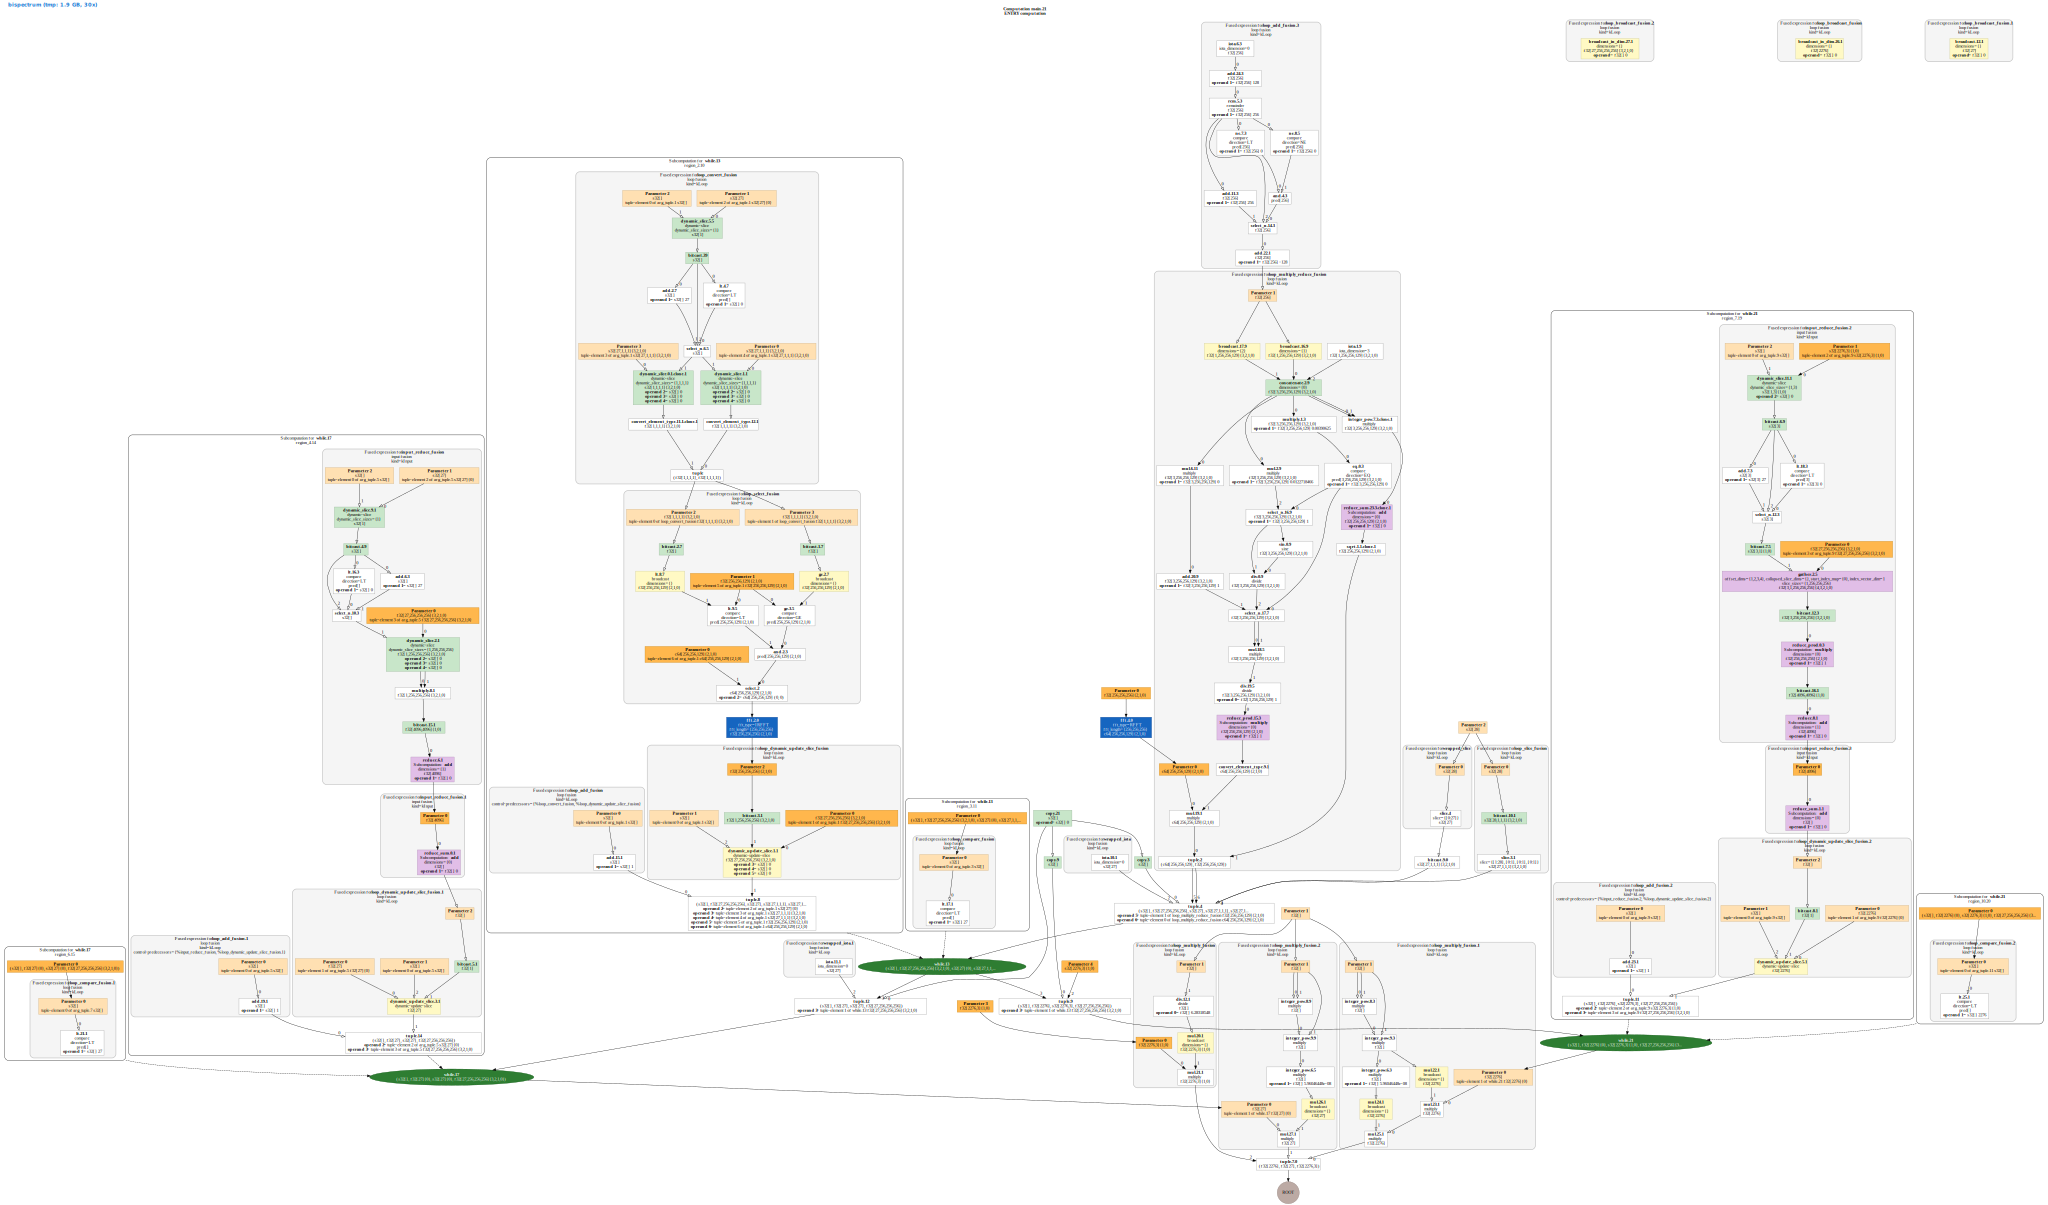

In [10]:
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, mas_order=2, sharding=None, fast=True, only_B=False, width=100)

--------  Memory usage of bispectrum  ---------
const : 104 B
code  : 56.0 kB
temp  : 1.9 GB
arg   : 64.1 MB
output: 35.6 kB
alias : 0 B
peak  : 2.0 GB


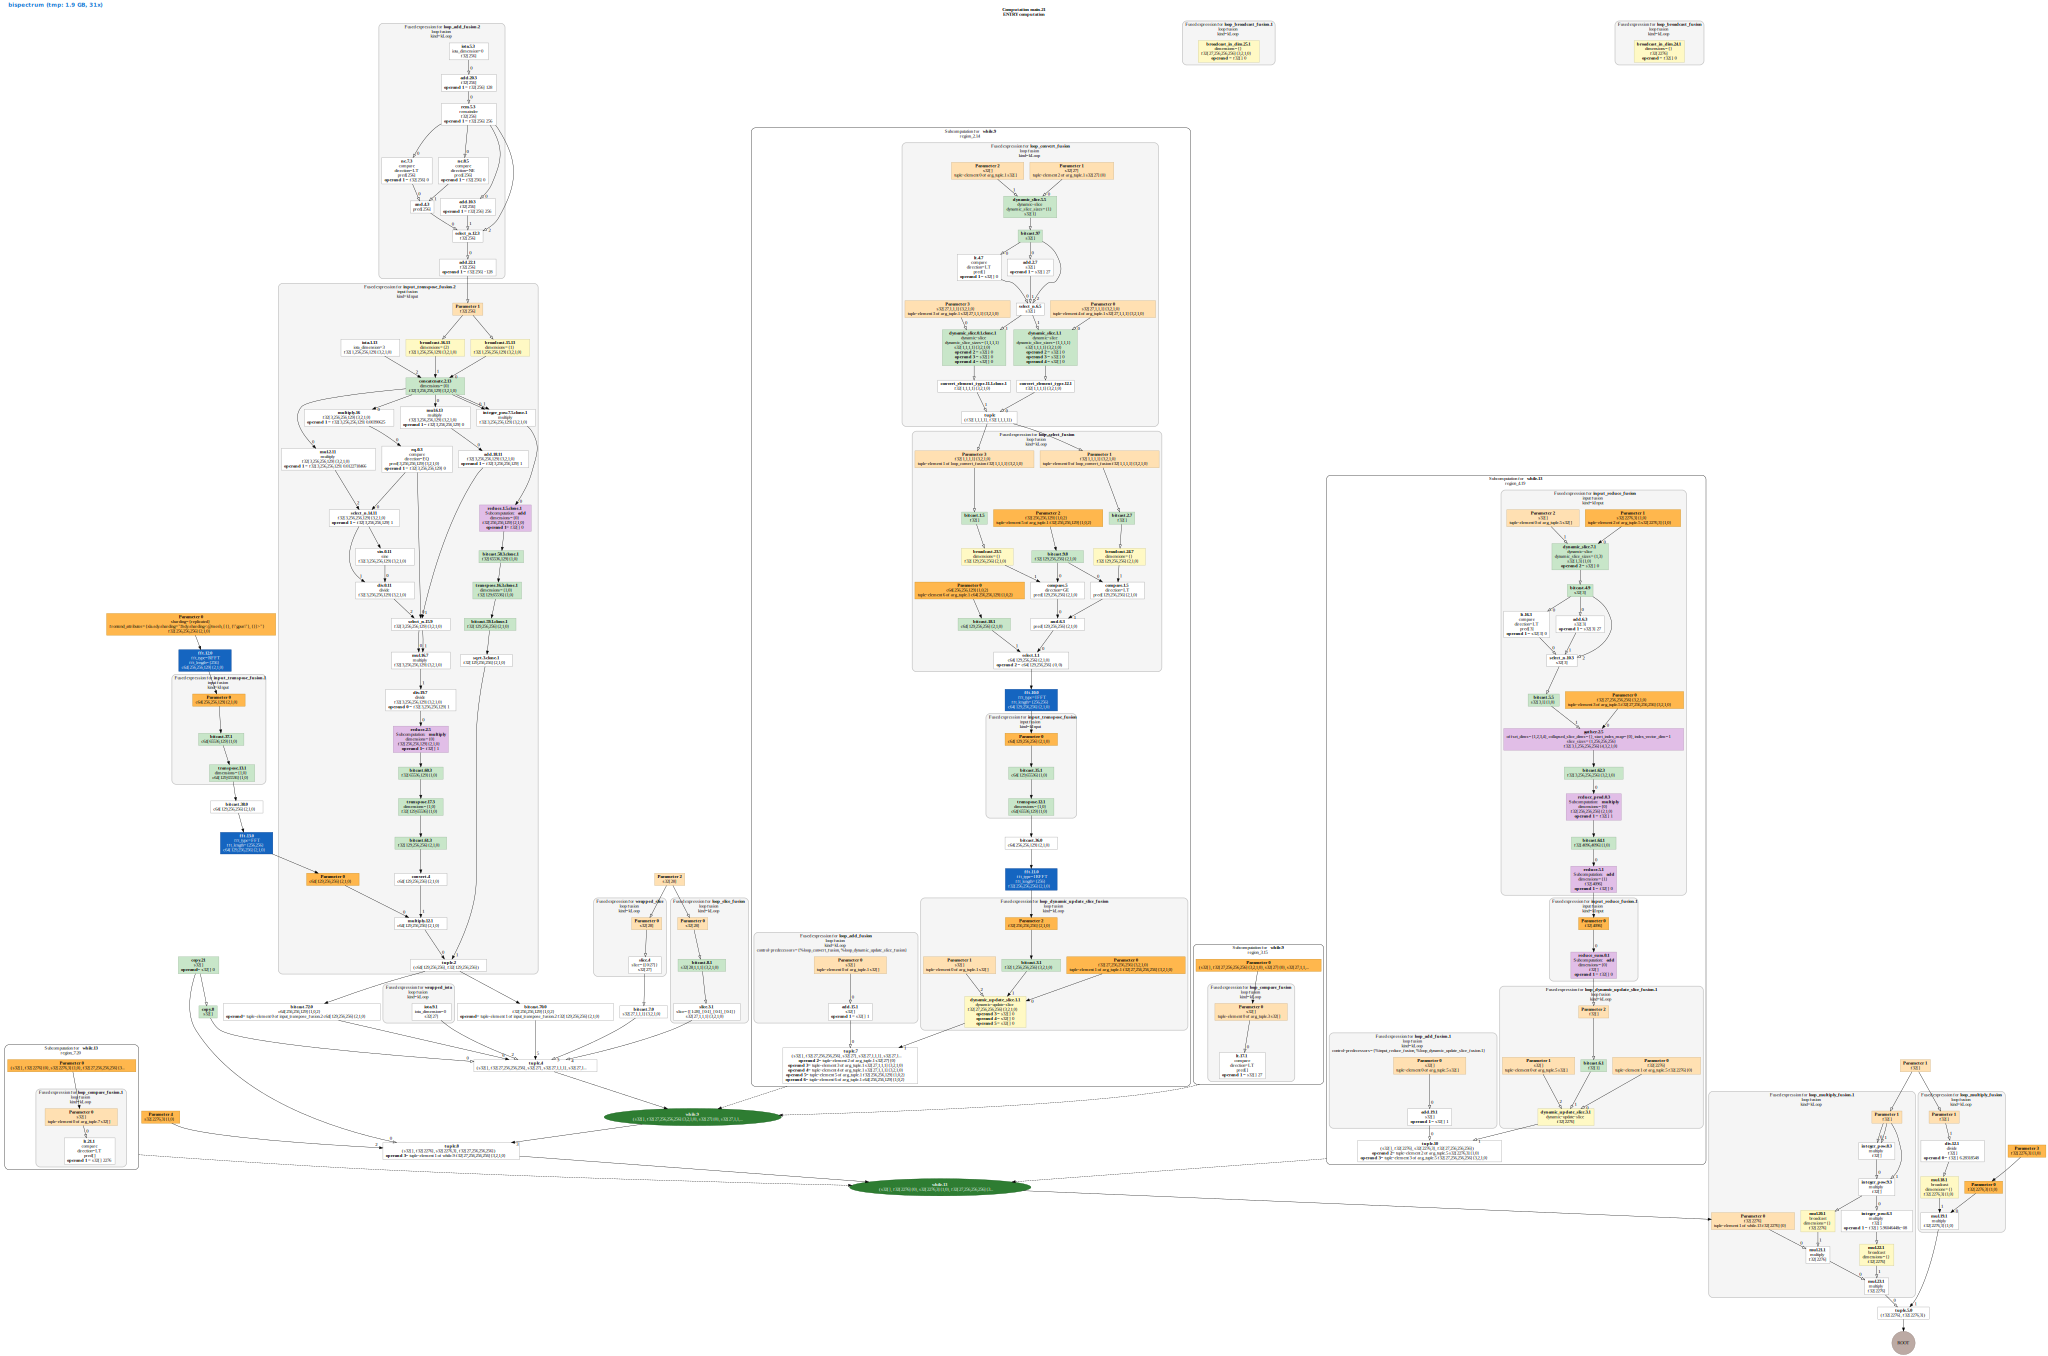

In [11]:
show_hlo_info(BFast.bispectrum.jit, sharded_field, boxsize, **B_info, mas_order=2, sharding=sharding, fast=True, width=100)

# Slow algorithm

In [12]:
%time results_unsharded_slow = BFast.Bk(field, boxsize, bins, mas_order=2, fast=False, jit=True, sharded=False, only_B=False)
%time results_unsharded_slow = BFast.Bk(field, boxsize, bins, mas_order=2, fast=False, jit=True, sharded=False, only_B=False)

CPU times: user 6.33 s, sys: 25.9 ms, total: 6.35 s
Wall time: 6.46 s
CPU times: user 5.69 s, sys: 3.16 ms, total: 5.7 s
Wall time: 5.71 s


In [13]:
%time results_sharded_slow = BFast.Bk(field, boxsize, bins, mas_order=2, fast=False, jit=True, sharded=True, only_B=False)
%time results_sharded_slow = BFast.Bk(field, boxsize, bins, mas_order=2, fast=False, jit=True, sharded=True, only_B=False)

CPU times: user 7.63 s, sys: 20.7 ms, total: 7.65 s
Wall time: 7.78 s
CPU times: user 6.92 s, sys: 2.87 ms, total: 6.92 s
Wall time: 6.94 s


--------  Memory usage of bispectrum  ---------
const : 112 B
code  : 64.4 kB
temp  : 417.3 MB
arg   : 64.1 MB
output: 35.7 kB
alias : 0 B
peak  : 481.3 MB


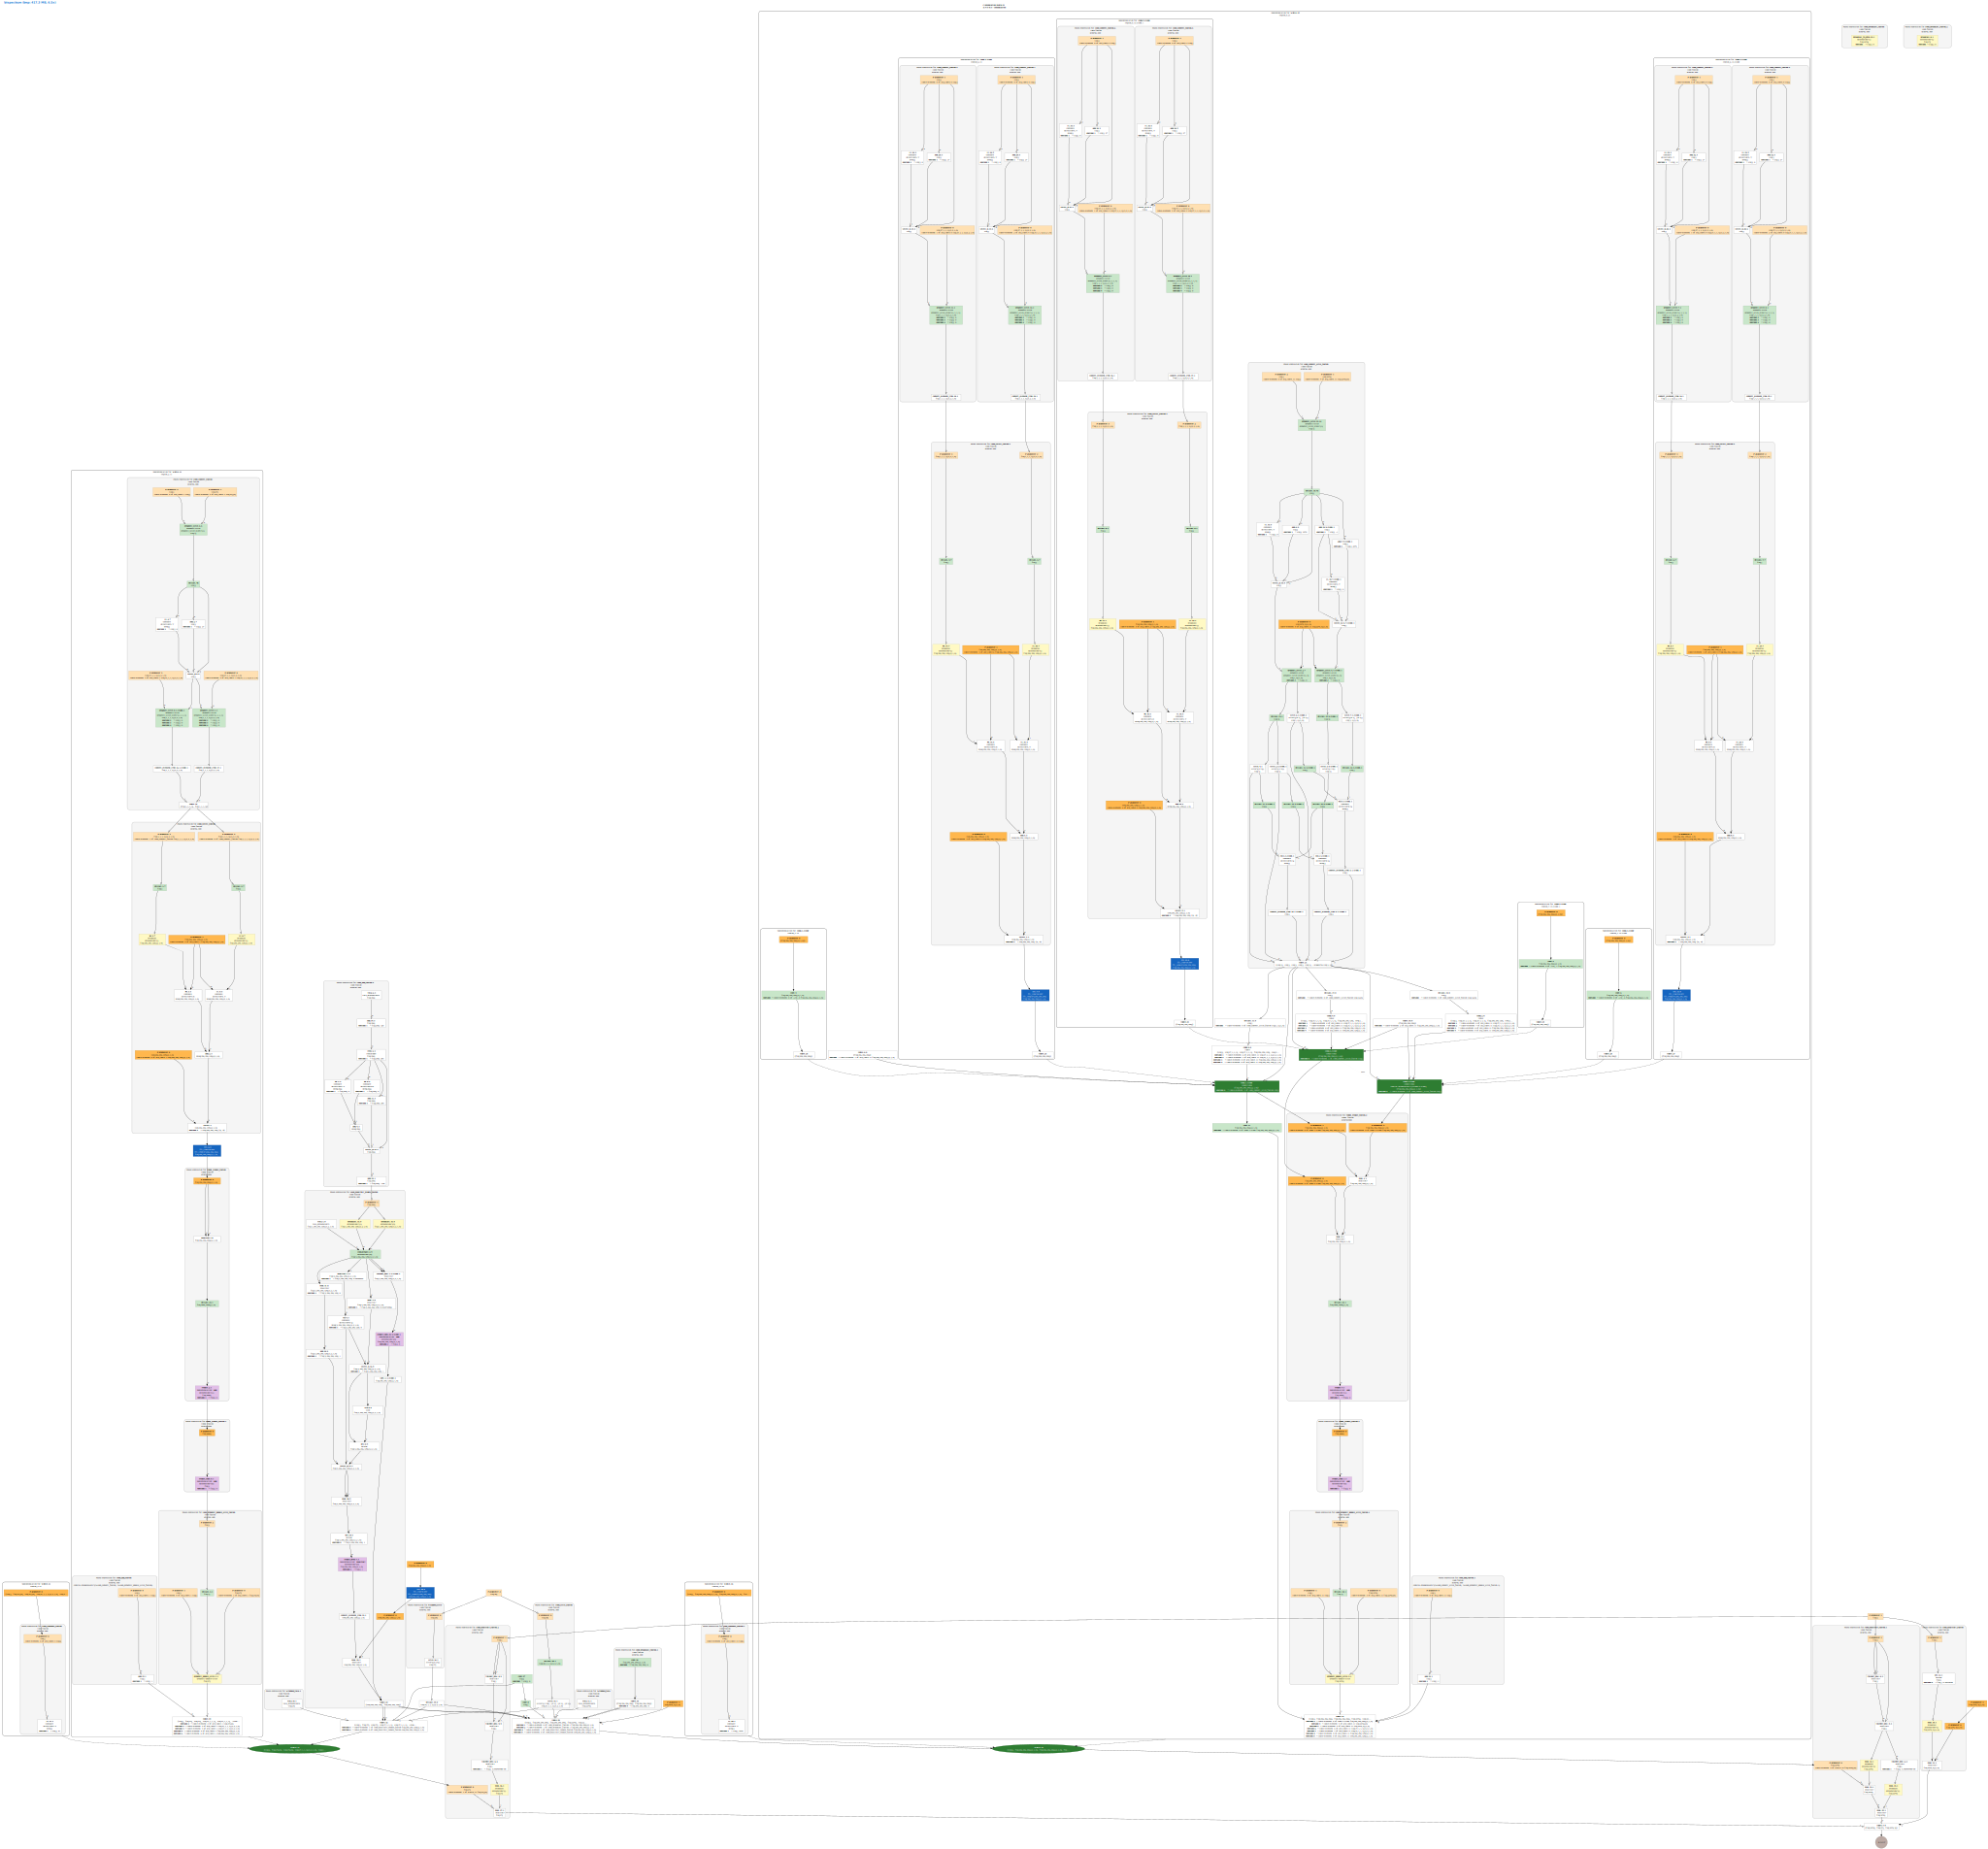

In [14]:
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, mas_order=2, sharding=None, fast=False, only_B=False, width=100)

--------  Memory usage of bispectrum  ---------
const : 100 B
code  : 56.5 kB
temp  : 481.8 MB
arg   : 64.1 MB
output: 35.6 kB
alias : 0 B
peak  : 481.8 MB


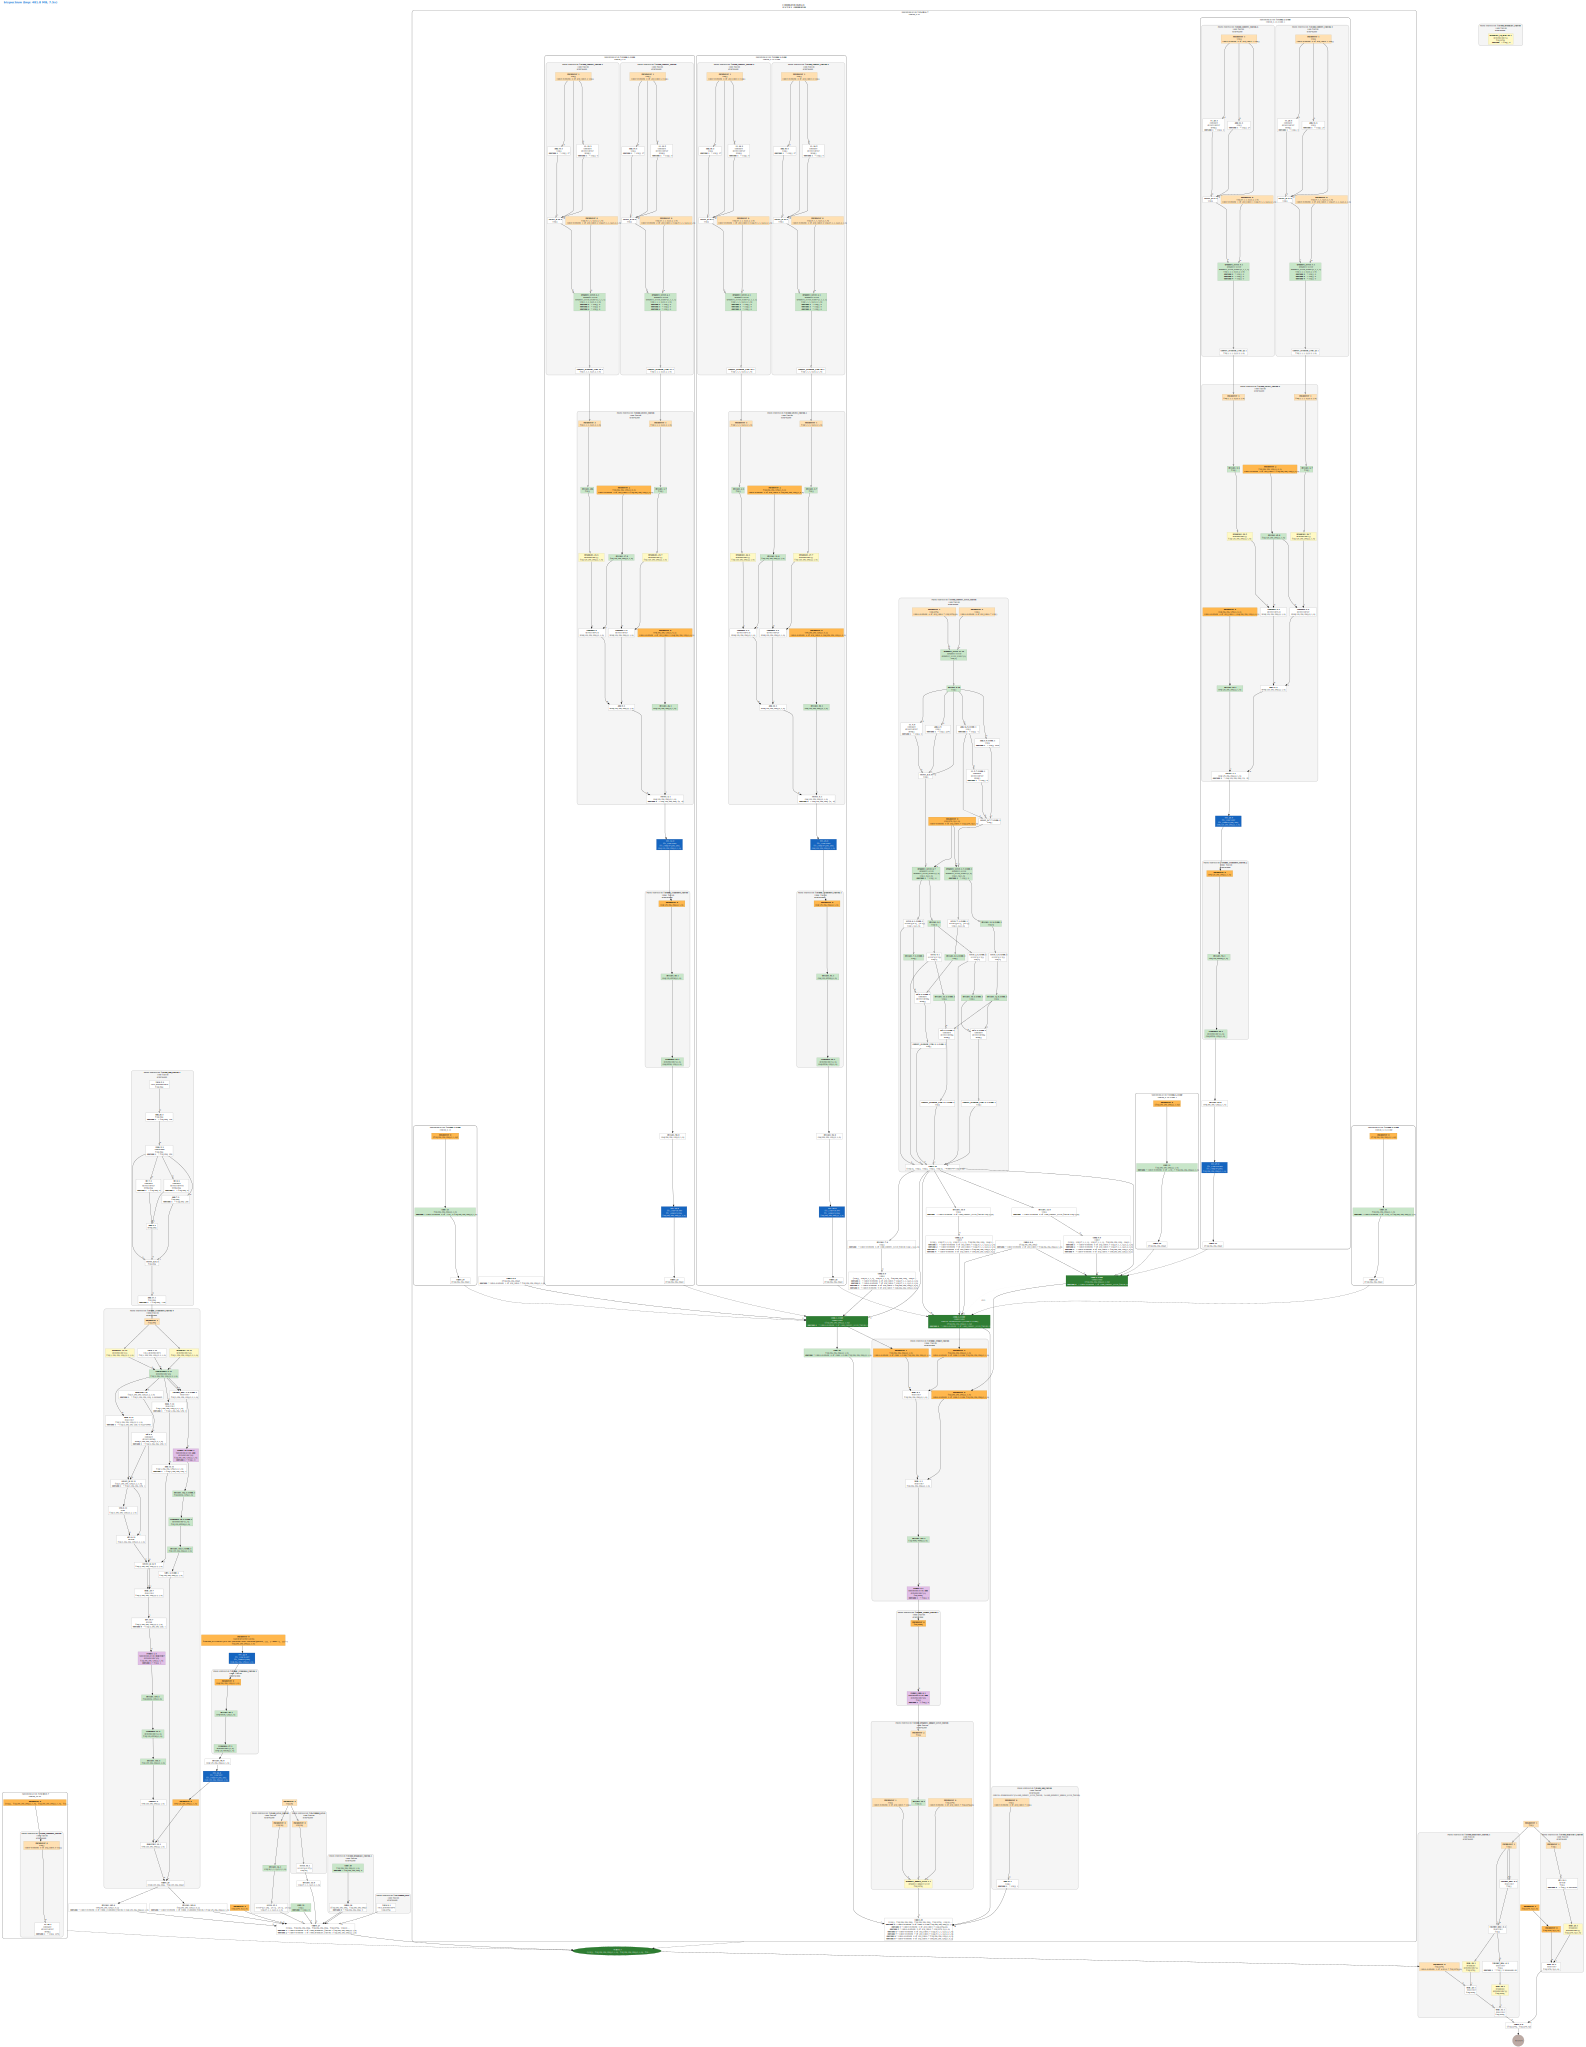

In [15]:
show_hlo_info(BFast.bispectrum.jit, sharded_field, boxsize, **B_info, mas_order=2, sharding=sharding, fast=False, width=100)

# Compare

In [16]:
rtol = 3e-4
for key in results_unsharded.keys():
    assert jnp.allclose(results_unsharded[key], results_sharded[key], rtol=rtol)
    assert jnp.allclose(results_unsharded[key], results_unsharded_slow[key], rtol=rtol)
    assert jnp.allclose(results_unsharded[key], results_sharded_slow[key],rtol=rtol)
    print(key, 'passed')

Bk passed
Pk passed
triangle_centers passed
